In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare


plt.rcParams["figure.figsize"] = (15, 8)

In [2]:
df = pd.read_csv('AB_Test_Results2.csv', sep=',')

df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [3]:
# We have outlier

df.describe()

,USER_ID,REVENUE
count,9997.000000,9997.000000
mean,4980.886566,0.083710
std,2890.805134,2.129166
min,2.000000,0.000000
25%,2468.000000,0.000000
50%,4962.000000,0.000000
75%,7513.000000,0.000000
max,10000.000000,196.010000


In [4]:
# Check if some people are in BOTH control and variant groups
 
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()

1    4785
2    1539
Name: VARIANT_NAME, dtype: int64

In [5]:
# We have some people that in both groups
# Select people that were only in one group

count_group = (df.groupby('USER_ID', as_index = False)['VARIANT_NAME'].nunique())

two_group_index = count_group[count_group.VARIANT_NAME == 1] 

In [6]:
df = df[df['USER_ID'].isin(two_group_index['USER_ID'])]

# Check if all correct
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()

1    4785
Name: VARIANT_NAME, dtype: int64

<AxesSubplot: xlabel='VARIANT_NAME', ylabel='REVENUE'>

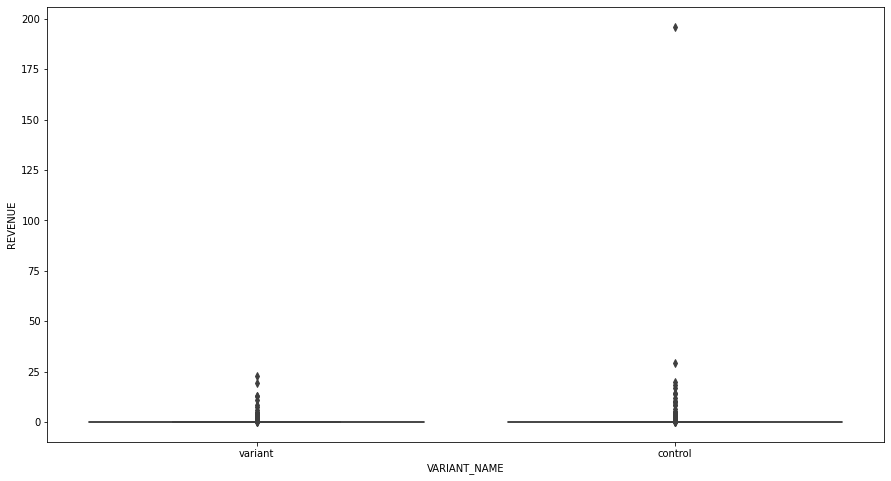

In [7]:
sns.boxplot(df, x = 'VARIANT_NAME', y = 'REVENUE')

In [8]:
# Looking for outlier

df.sort_values('REVENUE', ascending=False).head()

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8166,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47


In [9]:
df[df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


In [10]:
# That user has only one event, so we delete outlier

df = df[df.USER_ID != 3342]

<AxesSubplot: xlabel='VARIANT_NAME', ylabel='REVENUE'>

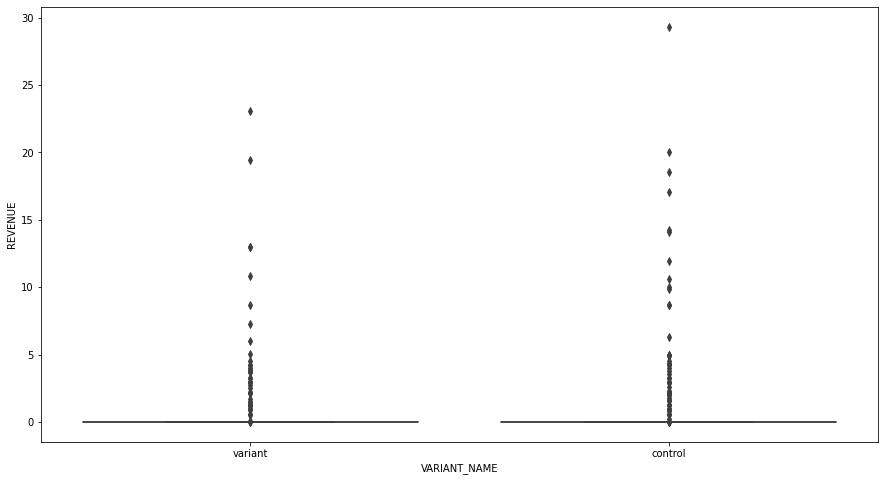

In [11]:
sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = df)

<AxesSubplot: xlabel='VARIANT_NAME', ylabel='REVENUE'>

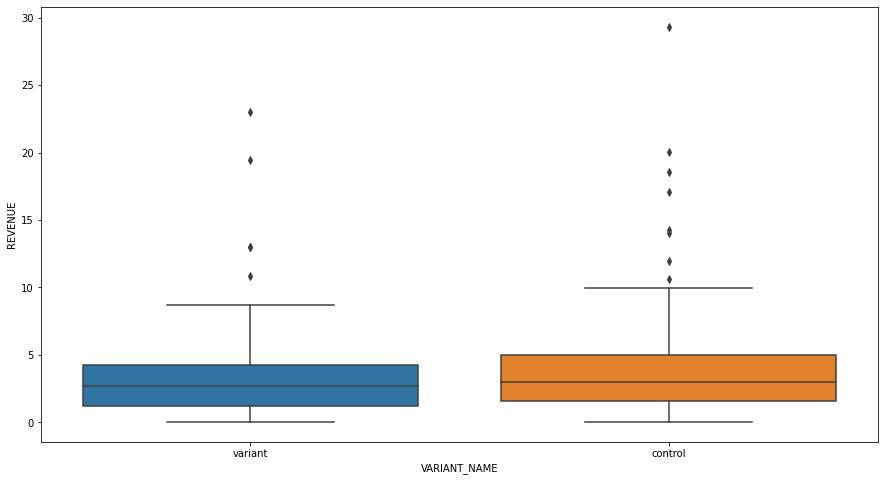

In [12]:
sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = df[df.REVENUE>0], order=['variant', 'control'])

In [13]:
# See if any user has several REVENUE values

df.groupby('USER_ID', as_index=False)['REVENUE'].count().head()

,USER_ID,REVENUE
0,2,3
1,4,1
2,5,1
3,6,1
4,9,1


In [14]:
# lets sum values of every user

df = df.groupby(['USER_ID', 'VARIANT_NAME'])['REVENUE'].sum().reset_index()

<AxesSubplot: xlabel='VARIANT_NAME', ylabel='REVENUE'>

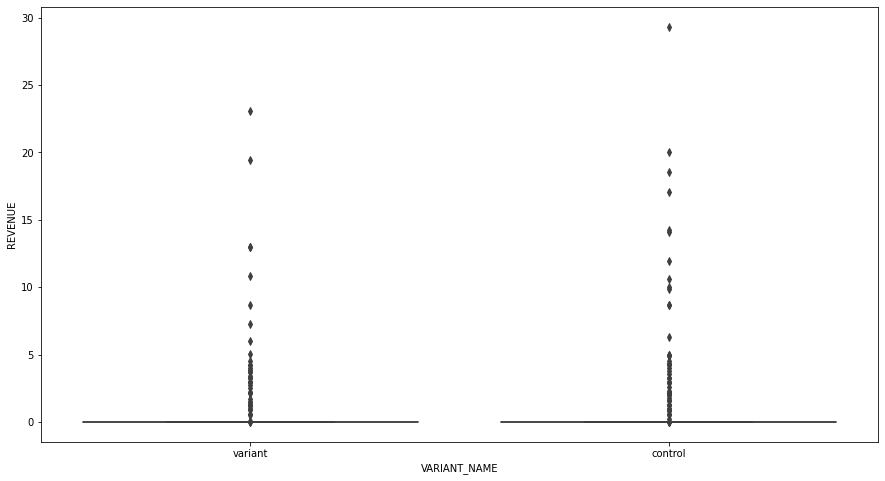

In [15]:
sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = df, order=['variant', 'control'])

<AxesSubplot: xlabel='VARIANT_NAME', ylabel='REVENUE'>

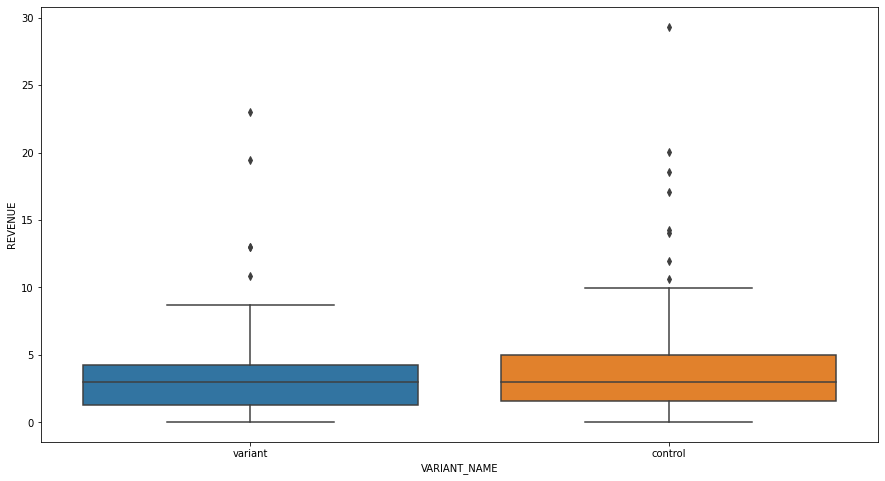

In [16]:
sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = df[df.REVENUE>0], order=['variant', 'control'])

In [17]:
# Check if the distribution is normal

from scipy.stats import shapiro

shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])

ShapiroResult(statistic=0.06143993139266968, pvalue=0.0)

In [18]:
# So we see that distribution is not normal

In [19]:
# U-test

from scipy.stats import mannwhitneyu 

test = df[df.VARIANT_NAME == 'variant']['REVENUE'].reset_index()
ctrl = df[df.VARIANT_NAME == 'control']['REVENUE'].reset_index()

mannwhitneyu(test, ctrl)

MannwhitneyuResult(statistic=array([2830418., 2847495.]), pvalue=array([0.52432828, 0.24800016]))

In [20]:
# only for those who has REVENUE > 0

mannwhitneyu(test[test.REVENUE > 0], ctrl[ctrl.REVENUE > 0])

MannwhitneyuResult(statistic=array([1307., 1029.]), pvalue=array([0.1470535 , 0.53141922]))

In [21]:
# p-value = 0.24800016
# p-value = 0.53141922 (only REVENUE>0)

In [22]:
# Bootstrap test

In [23]:
boot_results = bs.bootstrap_ab(  test.REVENUE.values, ctrl.REVENUE.values
                               , stat_func = bs_stats.mean
                               , compare_func = bs_compare.difference
                               , return_distribution = True)

In [24]:
boot_results

array([-0.02490876, -0.04660827, -0.05638307, ..., -0.05735992,
       -0.02234562, -0.05696222])

In [25]:
borders = np.percentile(boot_results, [2.5, 97.5])

borders

array([-0.09931209,  0.01649558])

C:\Users\valie\AppData\Local\Temp\ipykernel_13188\2560928721.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(boot_results)


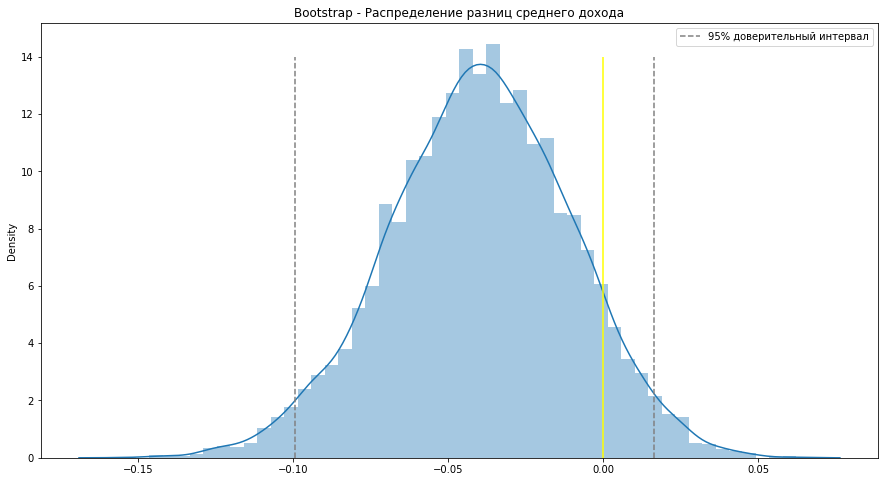

In [26]:
sns.distplot(boot_results)
plt.title('Bootstrap - Распределение разниц среднего дохода')
plt.vlines(0, ymin = 0, ymax = 14, colors = 'yellow', linestyles = '-')
plt.vlines(borders, ymin = 0, ymax = 14, colors = 'grey', linestyles = '--', label = '95% доверительный интервал')
plt.legend()
plt.show()

In [27]:
# Bootstrap only for REVENUE > 0

In [28]:
boot_results = bs.bootstrap_ab(  test[test.REVENUE > 0].REVENUE.values, ctrl[ctrl.REVENUE > 0].REVENUE.values
                               , stat_func = bs_stats.mean
                               , compare_func = bs_compare.difference
                               , return_distribution = True)

In [29]:
boot_results

array([-0.24126235, -2.65933962, -1.15813567, ..., -1.46666217,
       -1.23353998, -2.45543127])

In [30]:
borders = np.percentile(boot_results, [2.5, 97.5])

borders

array([-3.10519059,  1.23491431])

C:\Users\valie\AppData\Local\Temp\ipykernel_13188\487836473.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(boot_results)


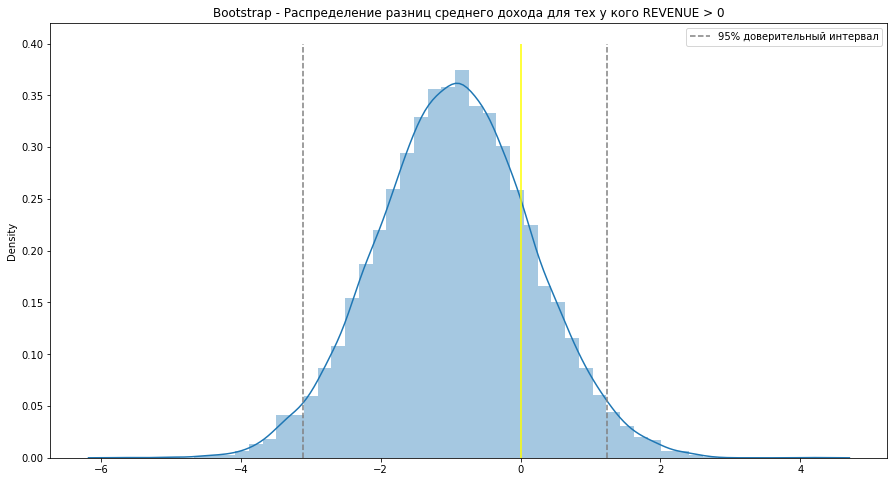

In [31]:
sns.distplot(boot_results)
plt.title('Bootstrap - Распределение разниц среднего дохода для тех у кого REVENUE > 0')
plt.vlines(0, ymin = 0, ymax = 0.4, colors = 'yellow', linestyles = '-')
plt.vlines(borders, ymin = 0, ymax = 0.4, colors = 'grey', linestyles = '--', label = '95% доверительный интервал')
plt.legend()
plt.show()

In [ ]:
# In both diagrams zero is within the confidence interval, so we CANNOT REJECT NULL HYPOTHESIS

In [32]:
# create convertion, chi-squared test, power analysis !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
# we need to read data one more time to get all columns later, that will appear later
df = pd.read_csv('AB_Test_Results2.csv', sep=',')

df.head(1)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0


In [33]:
# Clean data one more time from users that are both in the groups

df = df[df['USER_ID'].isin(two_group_index['USER_ID'])]

In [34]:
# Clean one outlier one more time

df = df[df.USER_ID != 3342]

In [35]:
# Create created_order column

def fun(row):
    if row['REVENUE'] > 0:
        return 1
    return 0

df['created_order'] = df.apply(lambda row: fun(row), axis=1)

df.head(30).tail()

,USER_ID,VARIANT_NAME,REVENUE,created_order
49,6429,control,3.25,1
52,7928,control,0.00,0
53,1544,variant,0.00,0
54,8467,variant,0.00,0
55,767,control,0.00,0


In [36]:
# Lets create convertion metric for each user (count appearences, sum revenue, number of created orders)
                                                 
df['count_user_id'] = df.groupby('USER_ID')['USER_ID'].transform('count')
df['sum_revenue'] = df.groupby('USER_ID')['REVENUE'].transform('sum')
df['num_created_orders'] = df.groupby('USER_ID')['created_order'].transform('sum')

In [37]:
# Lets check if everything is correct on some user

df.head(30).tail()

,USER_ID,VARIANT_NAME,REVENUE,created_order,count_user_id,sum_revenue,num_created_orders
49,6429,control,3.25,1,2,3.25,1
52,7928,control,0.00,0,1,0.00,0
53,1544,variant,0.00,0,2,0.00,0
54,8467,variant,0.00,0,1,0.00,0
55,767,control,0.00,0,1,0.00,0


In [38]:
# Create convertion_rate column

df['convertion_rate'] = df['num_created_orders']/df['count_user_id']*100

df.head(30).tail()

,USER_ID,VARIANT_NAME,REVENUE,created_order,count_user_id,sum_revenue,num_created_orders,convertion_rate
49,6429,control,3.25,1,2,3.25,1,50.0
52,7928,control,0.00,0,1,0.00,0,0.0
53,1544,variant,0.00,0,2,0.00,0,0.0
54,8467,variant,0.00,0,1,0.00,0,0.0
55,767,control,0.00,0,1,0.00,0,0.0


In [39]:
# Drop duplicate USER_ID (to prepare for chisquare test, we dont care about REVENUE and created_column columns)

df.shape

(6072, 8)

In [40]:
cleaned_df = df.drop_duplicates('USER_ID')

cleaned_df.shape

(4784, 8)

In [41]:
# Difference in convertion for control and variant groups

grouped_cleaned_df = cleaned_df.groupby('VARIANT_NAME').agg({'VARIANT_NAME':'count', 
                                        'convertion_rate':'mean'})
grouped_cleaned_df

,VARIANT_NAME,convertion_rate
VARIANT_NAME,,
control,2390,1.691074
variant,2394,1.421610


In [42]:
import statsmodels.stats.proportion as proportion

chi2stat, p_value, table = proportion.proportions_chisquare(cleaned_df['num_created_orders'], cleaned_df['count_user_id'])

p_value

0.6246351918990558

In [ ]:
# p-value more than 0.05 so we cannot reject NULL HYPOTHESIS 

In [43]:
# Power analysis

import statsmodels.stats.power as pwr

chipower = pwr.GofChisquarePower()

In [44]:
# Prepare variables for chi2
ctrl_conv_rate = grouped_cleaned_df['convertion_rate'].values[0]/100
test_conv_rate = grouped_cleaned_df['convertion_rate'].values[1]/100
nobs = min(grouped_cleaned_df['VARIANT_NAME'])

In [45]:
# Create function to find effect size

def chi2_solve_effect_size(a,b):
    return np.sqrt(((a-b)**2) / a)

In [46]:
chipower.solve_power(effect_size = chi2_solve_effect_size(ctrl_conv_rate, test_conv_rate),
                     nobs = nobs,
                     alpha = 0.05,
                     power = None)

0.17330880581549457

In [47]:
# Lets see how many nobs we need to get power = 0.8

round(chipower.solve_power(effect_size = chi2_solve_effect_size(ctrl_conv_rate, test_conv_rate),
                     nobs = None,
                     alpha = 0.05,
                     power = 0.8))

18280

In [48]:
# We need 18280 numbers of observations(for power=0.8), but we have only 4784
grouped_cleaned_df['VARIANT_NAME'].sum()

4784